# 概要
+ IRDB（https://irdb.nii.ac.jp/）から、JPCOAR加盟機関のデータをスクレイピングして、若干の分析を行う。
+ JPCOAR加盟機関は、https://jpcoar.repo.nii.ac.jp/page/40 から抽出し、「図書館」などの文字列を削除し、機関名を抽出

// https://irdb.nii.ac.jp/search?kikanid=&facet%5B0%5D=orgnm%3A2287　が文部科学省　科学技術・学術政策研究所　の番号らしい


In [ ]:
import pickle

inst_array = []
# insts = 　　[　　'東京大学',　　'東北大学',　　'東京工業大学'　　]
# 機関名を羅列したテキストファイルを読み込んで配列に代入
with open('kikanmei.txt', 'r',encoding="utf-8_sig") as f:
    insts = f.read().split("\n")

for inst in insts:
    inst_array.append(inst)

# 配列（list）をpickleに保存
with open("inst_array.pkl","wb") as f:
    pickle.dump(inst_array, f)

In [ ]:
import pickle

# 保存済みの機関名の配列を読み込み
with open('inst_array.pkl', 'rb') as f:
    institutions = pickle.load(f)
    
## 必要なライブラリのインポート ————–
# スクレイピング
from bs4 import BeautifulSoup
import time
import requests
import traceback
import logging
logger = logging.getLogger()

def main():
  type_list = {}
  #type_list = scrap('東北大学')
  for kikan in institutions:
    time.sleep(1)
    # 1秒スリープ
    type_list[kikan] = scrap(kikan)
    # type_list = scrap(kikan)
  # print(type_list)
  return type_list

def scrap(kikan):
  URL = 'https://irdb.nii.ac.jp/search?kikanid=' + kikan
  # スクレイピング —————————
  try:
    # URLを開く
    response = requests.get(URL)
    # HTMLを取得
    soup = BeautifulSoup(response.content, 'html.parser')
    logger.info('webサイトと接続できました')
  except:
    tb = traceback.format_exc()
    print(tb)
    print('Webサイトとの接続が確立できませんでした')

  # HTML上の任意の箇所を抽出
  '''
  <section class="facet-inactive block-facet--links block block-facets block-facet-blockresourcetype clearfix"
   id="block-resourcetype">
  <li class="facet-item"><a href="/search?kikanid=%E6%9D%B1%E4%BA%AC%E5%A4%A7%E5%AD%A6&amp;
  facet%5B0%5D=typefc%3Abook" rel="nofollow" 
  data-drupal-facet-item-id="typefc-book" data-drupal-facet-item-value="book"
  data-drupal-facet-item-count="109"><span class="facet-item__value">book</span>
  <span class="facet-item__count">(109)</span>
  '''
  soup2 = soup.select('#block-resourcetype a')
  # テキストのみをリストで取得
  soup_list = [[kikan, x.attrs['data-drupal-facet-item-value'], x.attrs['data-drupal-facet-item-count']] for x in soup2]
  return soup_list

# pickle　で置き換え
# institutions = ['東京大学','東北大学','東京工業大学']

if __name__ == "__main__":
    type_list = main()
    
# 600件で18分程度(sleep(1))

# データ加工
+ 機関名['institutions']をindexとし、資源タイプ['typename']ごとの数を表にする。

In [ ]:
# データ加工
import pandas as pd
# list化
listOfValues = list(type_list.values())
# フラット化
flat_list = [item for l in listOfValues for item in l]
koumoku = ['institutions', 'typename', 'nums']
# 項目名を加えて辞書化
listext = []
for v in flat_list:
    listext.append(dict(zip(koumoku,v)))

# pandasのDataFrame化
df = pd.DataFrame(listext)

# 縦持ちデータフレームdfを、横持ちに変換
pivot_orders_df = df.pivot_table(values=['nums'], index=['institutions'], columns=['typename'], aggfunc='sum')
pivot_orders_df = pivot_orders_df.rename(index={'': '全体'})
pivot_orders_df.fillna(0,inplace=True)
pivot_orders_df


In [ ]:
# pivot_orders_df
#pivot_orders_df_reset = pivot_orders_df.reset_index(level=0)
pivot_orders_df.columns = pivot_orders_df.columns.droplevel(0)
#pandas 0.18.0 and higher
pivot_orders_df = pivot_orders_df.rename_axis(None, axis=1)
pivot_orders_df

In [ ]:
# 数字に見えるものを数値化
cols = pivot_orders_df.columns
pivot_orders_df[cols] = pivot_orders_df[cols].apply(pd.to_numeric, errors='coerce')

In [2]:
# 前回保存したDataFrameのファイルから読み込む
import pandas as pd
pivot_orders_df = pd.read_pickle('./pivot_orders_df.pkl.gz', compression='gzip') # 圧縮有り

# 資源タイプ
+ 資源タイプは35個
+ Index(['article', 'bachelor thesis', 'book', 'book part',
       'cartographic material', 'conference object', 'conference paper',
       'conference poster', 'conference proceedings', 'data paper', 'dataset',
       'departmental bulletin paper', 'doctoral thesis', 'editorial', 'image',
       'interview', 'journal article', 'learning object', 'lecture',
       'manuscript', 'master thesis', 'musical notation', 'newspaper', 'other',
       'periodical', 'report', 'report part', 'research report',
       'review article', 'software', 'sound', 'still image',
       'technical report', 'thesis', 'working paper'],
      dtype='object')
    + ただし、JPCOARスキーマ 語彙としては47ある
    + 語彙
conference paper
data paper
departmental bulletin paper
editorial
journal article
newspaper
periodical
review article
software paper
article
book
book part
cartographic material
map
conference object
conference proceedings
conference poster
dataset
interview
image
still image
moving image
video
lecture
patent
internal report
report
research report
technical report
policy report
report part
working paper
data management plan
sound
thesis
bachelor thesis
master thesis
doctoral thesis
interactive resource
learning object
manuscript
musical notation
research proposal
software
technical documentation
workflow
other

    

In [7]:
pivot_orders_df.columns # 資源タイプ名をリスト化
# 全体の情報を表示
#　pivot_orders_df.info()

Index(['article', 'bachelor thesis', 'book', 'book part',
       'cartographic material', 'conference object', 'conference paper',
       'conference poster', 'conference proceedings', 'data paper', 'dataset',
       'departmental bulletin paper', 'doctoral thesis', 'editorial', 'image',
       'interview', 'journal article', 'learning object', 'lecture',
       'manuscript', 'master thesis', 'musical notation', 'newspaper', 'other',
       'periodical', 'report', 'report part', 'research report',
       'review article', 'software', 'sound', 'still image',
       'technical report', 'thesis', 'working paper'],
      dtype='object')

In [9]:
# 'article == 113164'は総計の数字。IRDBは検索該当なしだと全件になってしまうので。
# IRDBは、JPCOAR外のリポジトリも含んだ数字なので、総計は削除してよい
# print((pivot_orders_df.query('article == 113164')))
pivot_orders_df_2index = list(pivot_orders_df.query('article == 113164').index)
# del pivot_orders_df_2index[:2]  # 先頭から２つ[全体,＃NA]をlistから削除する場合
pivot_orders_df_2index  # 削除するindexのlist
# index で指定した行をまとめて削除したDFを生成
pivot_orders_df2 = pivot_orders_df.drop(index=pivot_orders_df_2index)

In [ ]:
# 試しに階層型クラスタリングして、デンドログラムを書いてみる。あまり役に立たない？
# 階層型クラスタリング(ウォード法)
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
 
linkage_result = linkage(pivot_orders_df2, method='ward', metric='euclidean')
plt.figure(num=None, figsize=(16, 9), dpi=200, facecolor='w', edgecolor='k')
dendrogram(linkage_result, labels=pivot_orders_df2.index)
plt.show()
# 24.4s

# 階層型クラスタリング
+ ユークリッド距離とウォード法または群平均法を使用してクラスタリング
    + average:群平均法：クラスター分析で使用される、クラスター間の距離算出方法の一つ。 2つのクラスター間で可能な全ての組み合わせにおける非類似度の平均からクラスターを形成する方法。
## 結果
- 3 Index(['お茶の水女子大学', 'こども教育宝仙大学', 'つくば国際大学', 'びわこ成蹊スポーツ大学', 'ものつくり大学',
       'アジア成長研究所', 'デジタルハリウッド大学', 'ノートルダム清心女子大学', 'フェリス女学院大学', 'ヤマザキ動物看護大学',
       ...
       '鶴見大学', '鹿児島国際大学', '鹿児島大学', '鹿児島女子短期大学', '鹿児島県立短期大学', '鹿児島純心女子大学',
       '鹿児島純心女子短期大学', '鹿屋体育大学', '麗澤大学', '麻布大学'],
      dtype='object', name='institutions', length=602)
- 6 Index(['京都大学'], dtype='object', name='institutions')
- 4 Index(['北海道大学', '大阪大学', '早稲田大学', '東京大学', '筑波大学'], dtype='object', name='institutions')
- 5 Index(['千葉大学'], dtype='object', name='institutions')
- 1 Index(['慶應義塾大学'], dtype='object', name='institutions')
- 7 Index(['東京工業大学'], dtype='object', name='institutions')
- 2 Index(['東北大学'], dtype='object', name='institutions')

In [11]:
# 【python】scipyで階層型クラスタリングするときの知見まとめ
# https://www.haya-programming.com/entry/2019/02/11/035943#linkage
import numpy as np
from collections import defaultdict
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.datasets import load_digits

def gen_data():
    digits = load_digits()
    label_uniq = np.unique(digits.target)
    result = []
    for label in label_uniq:
        result.append(digits.data[digits.target == label].mean(axis=0))
    return result, label_uniq

def clustering_fcluster():
    X, y = gen_data()
    S = pdist(X)
    # methods = ["single", "complete", "average", "weighted", "centroid", "median", "ward"]
    # Z = linkage(pivot_orders_df2, metric='euclidean', method='ward')
    Z = linkage(pivot_orders_df2, metric='euclidean', method='average')
    # Z = linkage(pivot_orders_df2, method="average")
    # criterion= ‘maxclust’、最大クラスタ数
    # ’distance’ 距離で閾値を指定
    # inconsistent (default)
    # monocrit, maxclust_monocrit
    result = fcluster(Z, t=7, criterion="maxclust")
    # result = fcluster(Z, t=5, criterion="distance")
    d = defaultdict(list)
    for i, r in enumerate(result):
        d[r].append(i)
    for k, v in d.items():
        print(k, pivot_orders_df2.index[v])
        # print(k,v) # v は行番号のリスト
        
if __name__ == "__main__":
    clustering_fcluster()

3 Index(['お茶の水女子大学', 'こども教育宝仙大学', 'つくば国際大学', 'びわこ成蹊スポーツ大学', 'ものつくり大学',
       'アジア成長研究所', 'デジタルハリウッド大学', 'ノートルダム清心女子大学', 'フェリス女学院大学', 'ヤマザキ動物看護大学',
       ...
       '鶴見大学', '鹿児島国際大学', '鹿児島大学', '鹿児島女子短期大学', '鹿児島県立短期大学', '鹿児島純心女子大学',
       '鹿児島純心女子短期大学', '鹿屋体育大学', '麗澤大学', '麻布大学'],
      dtype='object', name='institutions', length=602)
6 Index(['京都大学'], dtype='object', name='institutions')
4 Index(['北海道大学', '大阪大学', '早稲田大学', '東京大学', '筑波大学'], dtype='object', name='institutions')
5 Index(['千葉大学'], dtype='object', name='institutions')
1 Index(['慶應義塾大学'], dtype='object', name='institutions')
7 Index(['東京工業大学'], dtype='object', name='institutions')
2 Index(['東北大学'], dtype='object', name='institutions')


In [12]:
# 行と列に合計値を追加する 
pivot_orders_df3 = pd.concat([pivot_orders_df2,pd.DataFrame(pivot_orders_df2.sum(axis=0),columns=['Grand Total']).T])
pivot_orders_df3 = pd.concat([pivot_orders_df2,pd.DataFrame(pivot_orders_df2.sum(axis=1),columns=['Total'])],axis=1)
pivot_orders_df3

,article,bachelor thesis,book,book part,cartographic material,conference object,conference paper,conference poster,conference proceedings,data paper,...,report part,research report,review article,software,sound,still image,technical report,thesis,working paper,Total
institutions,,,,,,,,,,,,,,,,,,,,,
お茶の水女子大学,17818,0,55,0,0,61,133,0,0,0,...,0,619,0,0,0,0,0,0,0,39468
こども教育宝仙大学,0,0,3,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,162
つくば国際大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,569
びわこ成蹊スポーツ大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,125,2062,0,2944
ものつくり大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,159
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
鹿児島純心女子大学,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,445
鹿児島純心女子短期大学,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,103
鹿屋体育大学,0,0,0,0,0,0,0,0,0,0,...,0,230,0,0,0,0,0,33,0,1158


In [13]:
# Totalの降順にソートする
pivot_orders_df4 = pivot_orders_df3.sort_values(by='Total', ascending=False) 
# 日付をファイル名にしてエクセルに出力
import datetime
now = datetime.datetime.now()
filename = './irdbscraping_' + now.strftime('%Y%m%d_%H%M%S') + '.xlsx'
pivot_orders_df4.to_excel('./'+filename, sheet_name='filename')

In [41]:
pivot_orders_df4.columns

Index(['article', 'bachelor thesis', 'book', 'book part',
       'cartographic material', 'conference object', 'conference paper',
       'conference poster', 'conference proceedings', 'data paper', 'dataset',
       'departmental bulletin paper', 'doctoral thesis', 'editorial', 'image',
       'interview', 'journal article', 'learning object', 'lecture',
       'manuscript', 'master thesis', 'musical notation', 'newspaper', 'other',
       'periodical', 'report', 'report part', 'research report',
       'review article', 'software', 'sound', 'still image',
       'technical report', 'thesis', 'working paper', 'Total'],
      dtype='object')

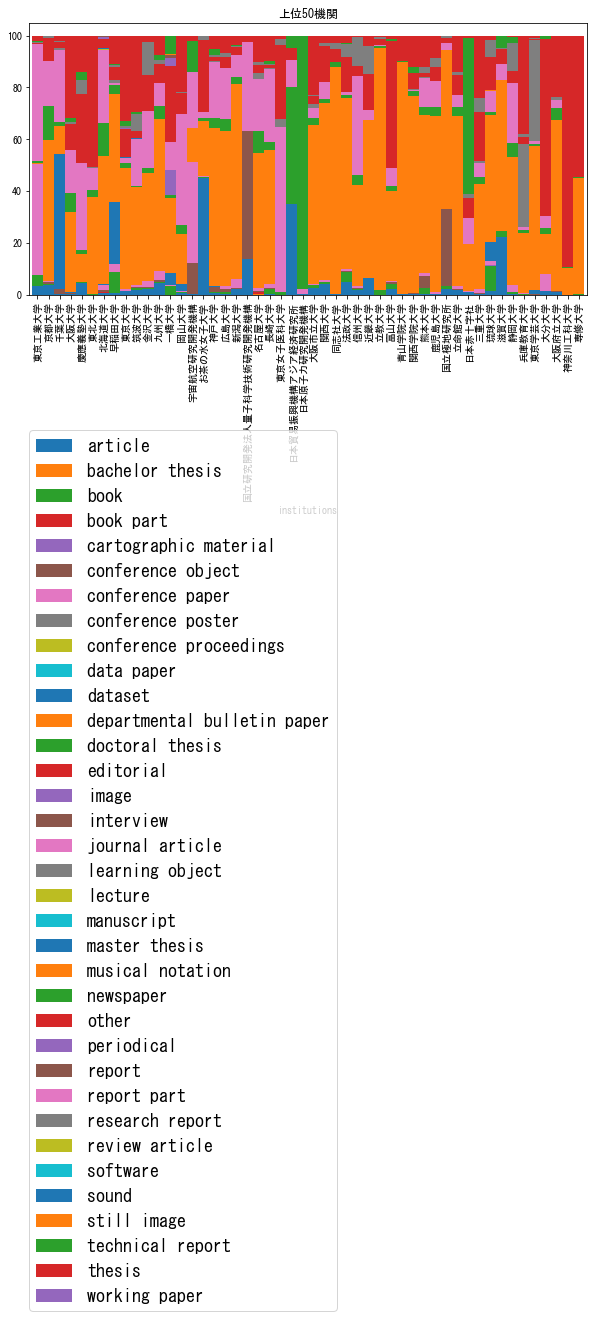

In [38]:
# グラフの文字化け対策
from matplotlib import rcParams
plt.rcParams["font.family"] = "MS Gothic"
# df.iloc[:, 1:] = df.iloc[:, 1:].div(df['total'], axis=0).mul(100).round(2).astype(str).add(' %')
# 行ごとの百分率に変換する
pivot_orders_df5 = pivot_orders_df4.div(pivot_orders_df4['Total'], axis=0).mul(100)  # .round(2) 四捨五入
# df.drop("b", axis=1)
# pivot_orders_df5.iloc[:50,].drop("Total", axis=1).plot.bar(stacked=True)  
# .iloc[:12,] 12機関目までにする
# 判例の位置調整　https://qiita.com/matsui-k20xx/items/291400ed56a39ed63462
pivot_orders_df5.iloc[:50,].drop("Total", axis=1)\
    .plot(kind='bar', stacked=True, figsize=(10,5), width=1, linewidth=0,title='上位50機関',)\
    .legend(bbox_to_anchor=(0, -0.5), loc='upper left', borderaxespad=0, fontsize=18)
   
# iloc() を使って 列をスライスする
# pivot_orders_df5.iloc[:12, 0:34].plot.bar(stacked=True)
# pivot_orders_df5.loc[:12, 'article':'working paper'].plot.bar(stacked=True)

<ipython-input-51-0ca3ed5cc0ad>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  pivot_orders_df5.hist(ax=ax)


array([[<AxesSubplot:title={'center':'article'}>,
        <AxesSubplot:title={'center':'bachelor thesis'}>,
        <AxesSubplot:title={'center':'book'}>,
        <AxesSubplot:title={'center':'book part'}>,
        <AxesSubplot:title={'center':'cartographic material'}>,
        <AxesSubplot:title={'center':'conference object'}>],
       [<AxesSubplot:title={'center':'conference paper'}>,
        <AxesSubplot:title={'center':'conference poster'}>,
        <AxesSubplot:title={'center':'conference proceedings'}>,
        <AxesSubplot:title={'center':'data paper'}>,
        <AxesSubplot:title={'center':'dataset'}>,
        <AxesSubplot:title={'center':'departmental bulletin paper'}>],
       [<AxesSubplot:title={'center':'doctoral thesis'}>,
        <AxesSubplot:title={'center':'editorial'}>,
        <AxesSubplot:title={'center':'image'}>,
        <AxesSubplot:title={'center':'interview'}>,
        <AxesSubplot:title={'center':'journal article'}>,
        <AxesSubplot:title={'center':'lear

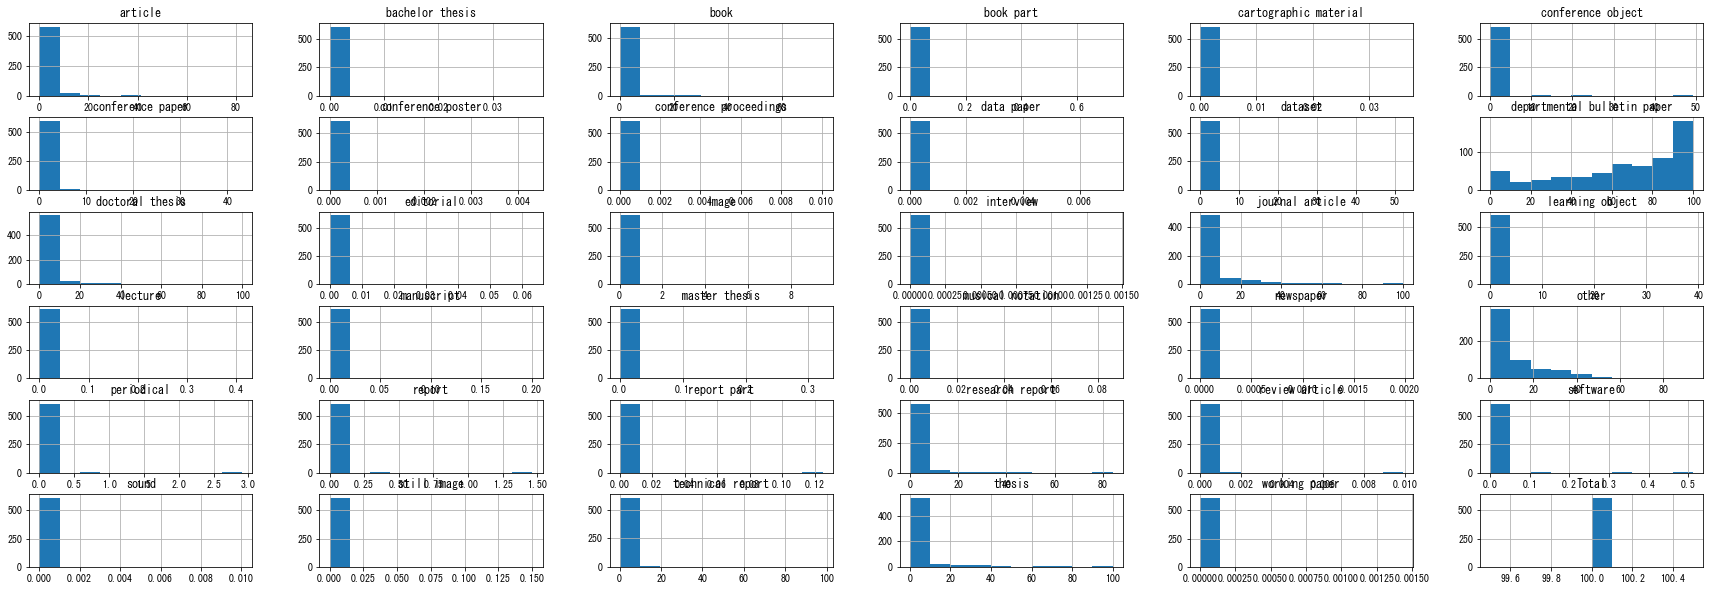

In [51]:
# 各列のヒストグラムを作成
plt.rcParams['font.size'] = 10
fig, ax = plt.subplots(figsize=(30,10))
pivot_orders_df5.hist(ax=ax)

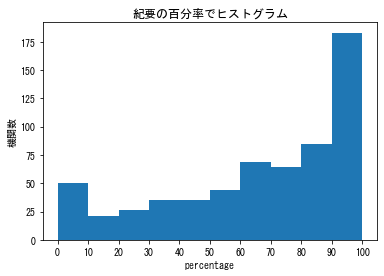

In [48]:
# 紀要['departmental bulletin paper']の個数でソートしたものを kiyou とする
kiyou = pivot_orders_df5.sort_values(by='departmental bulletin paper', ascending=False) 
# 紀要が90%以上　>90 のもの
# print(kiyou['departmental bulletin paper'][kiyou['departmental bulletin paper'] < 70])  #  == 100
# kiyou['departmental bulletin paper'].hist(bins=20) # これが単純でよい

import matplotlib.pyplot as plt
# タイトル追加
plt.title('紀要の百分率でヒストグラム')
# x軸にscore、y軸にfreq
plt.xlabel('percentage')
plt.ylabel('機関数')
# 目盛りを変更
plt.xticks([0,10,20,30,40,50,60,70,80,90,100]) 
# ヒストグラムを描画する（表示する幅は50〜100）、階級数（棒の数）は20
plt.hist(kiyou['departmental bulletin paper'], range=(00, 100), bins=10);

In [ ]:
pivot_orders_df.to_pickle('./pivot_orders_df.pkl.gz', compression='gzip') # 圧縮有り
# pd.read_pickle('test.pkl.gz', compression='gzip') # 圧縮有り